<a href="https://colab.research.google.com/github/BhavanaTK/Time-Series-Prediction-of-House-Hold-Electricity-Consumption/blob/main/Time_Series_Prediction_of_Household_Electricity_Consumption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv(r'C:\Users\hp\Downloads\household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])

# Combine Date and Time into a single datetime column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop original Date and Time columns
data.drop(columns=['Date', 'Time'], inplace=True)

# Set datetime as the index
data.set_index('datetime', inplace=True)

# Convert columns to numeric (forcing errors to NaN)
cols = data.columns
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by forward filling and then backward filling
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

print(data.head())


                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

## EXPLORATORY DATA ANALYSIS

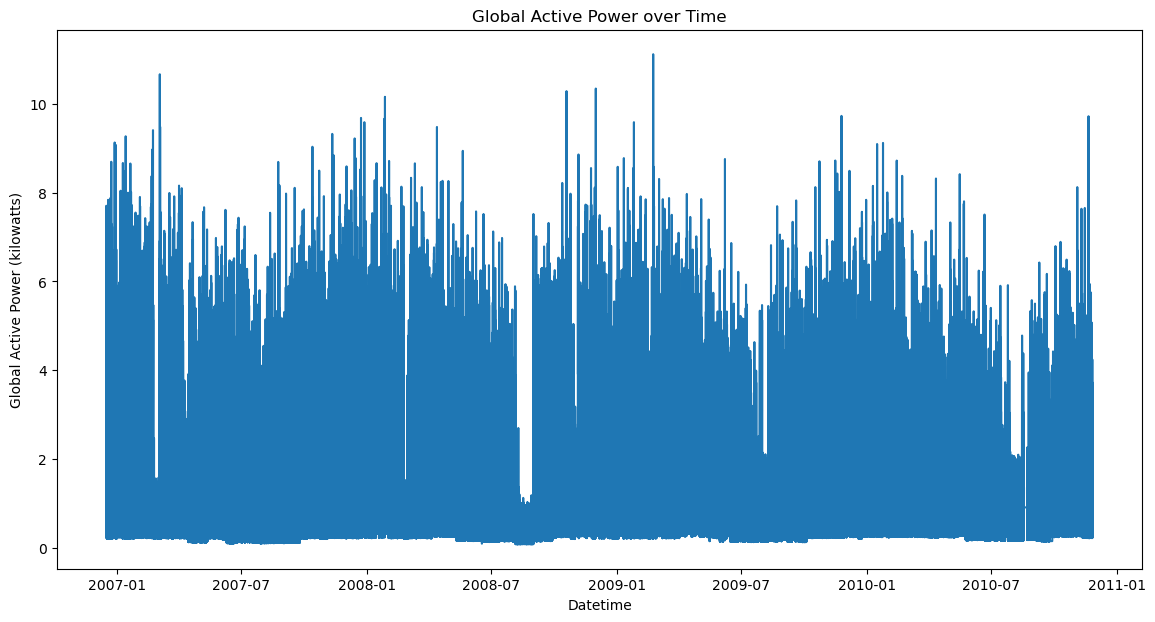

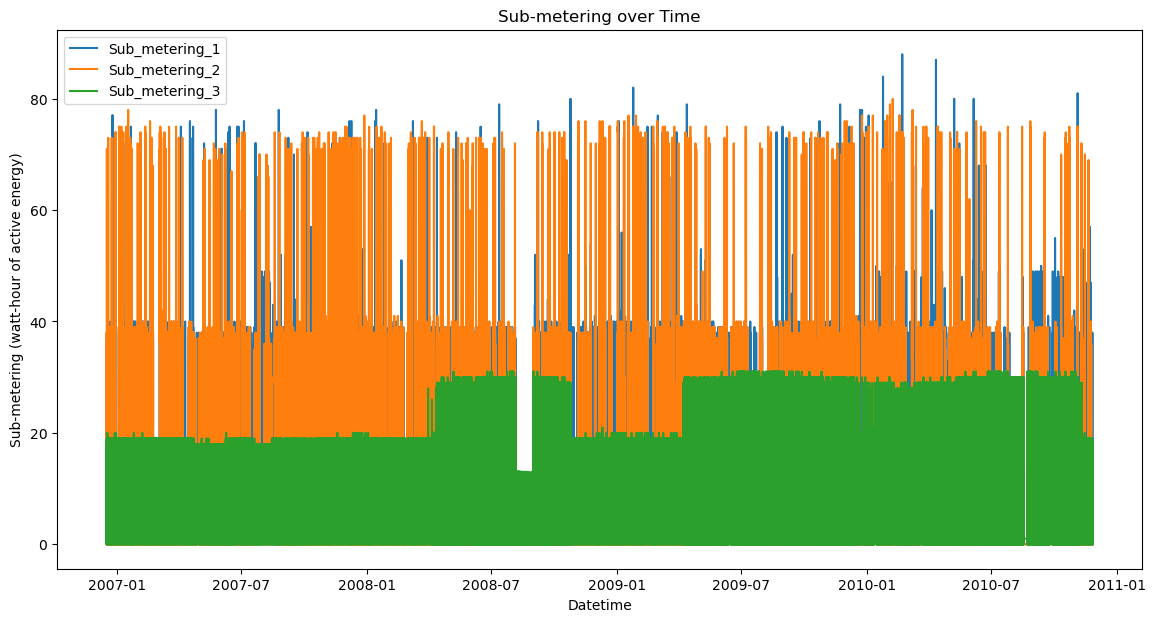

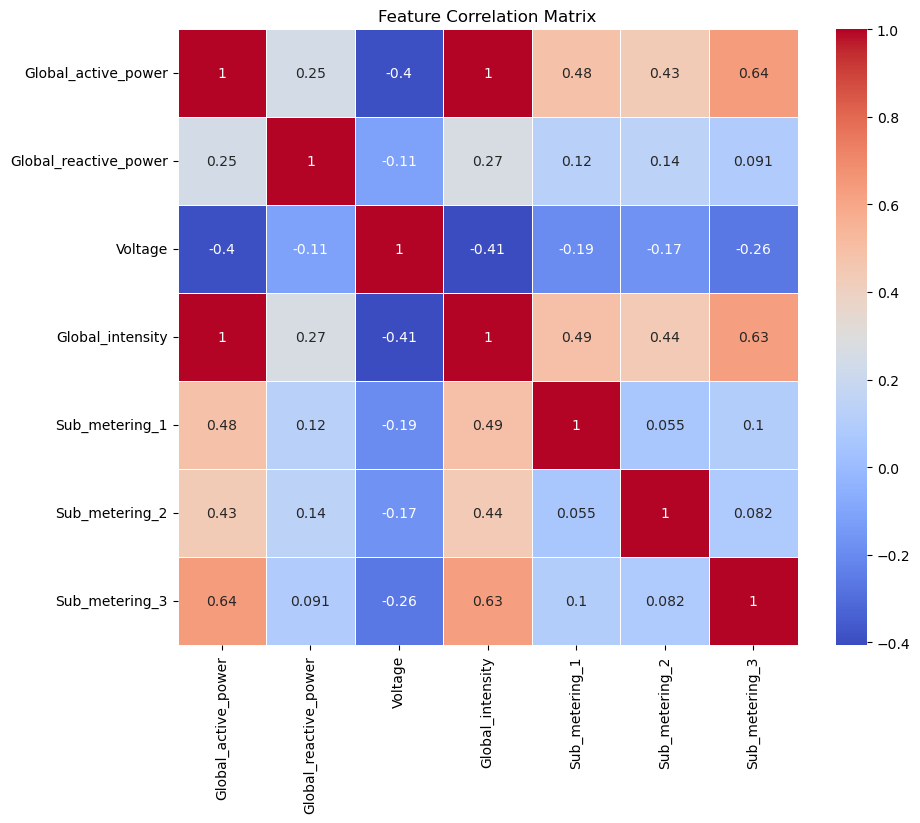

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting global active power over time
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Global_active_power'])
plt.title('Global Active Power over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

# Plotting sub-metering over time
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Sub_metering_1'], label='Sub_metering_1')
plt.plot(data.index, data['Sub_metering_2'], label='Sub_metering_2')
plt.plot(data.index, data['Sub_metering_3'], label='Sub_metering_3')
plt.title('Sub-metering over Time')
plt.xlabel('Datetime')
plt.ylabel('Sub-metering (watt-hour of active energy)')
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


## TIME SERIES FORCASTING MODEL

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 1.2259390432827406


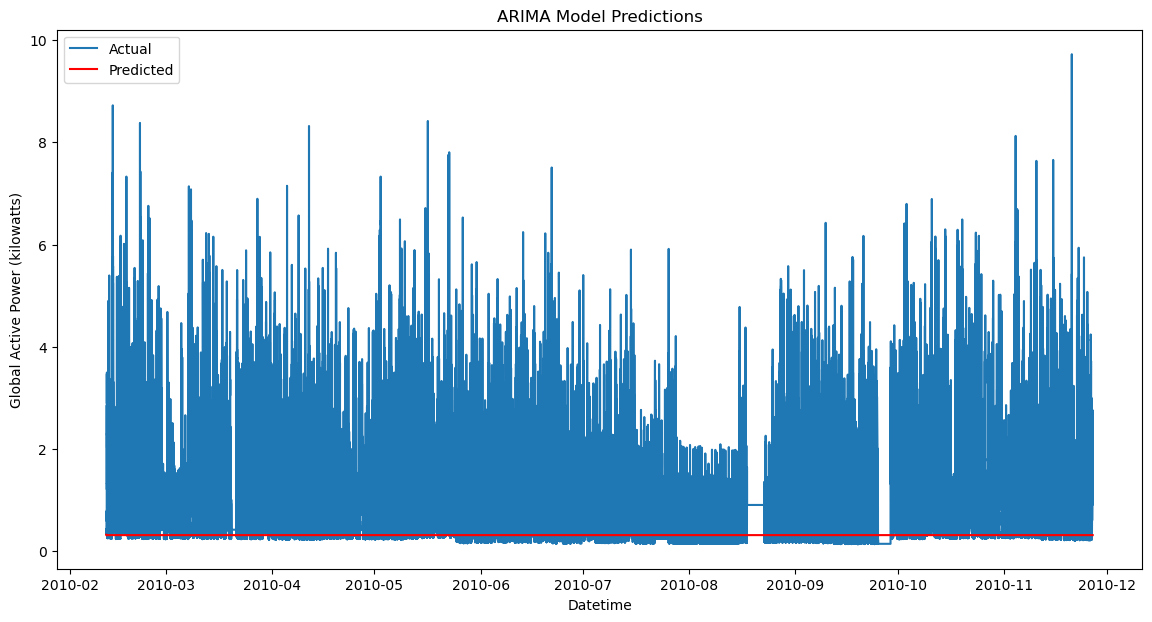

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Use Global_active_power for forecasting
series = data['Global_active_power']

# Split the data into train and test sets
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Evaluate predictions
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


## Feature Engineering

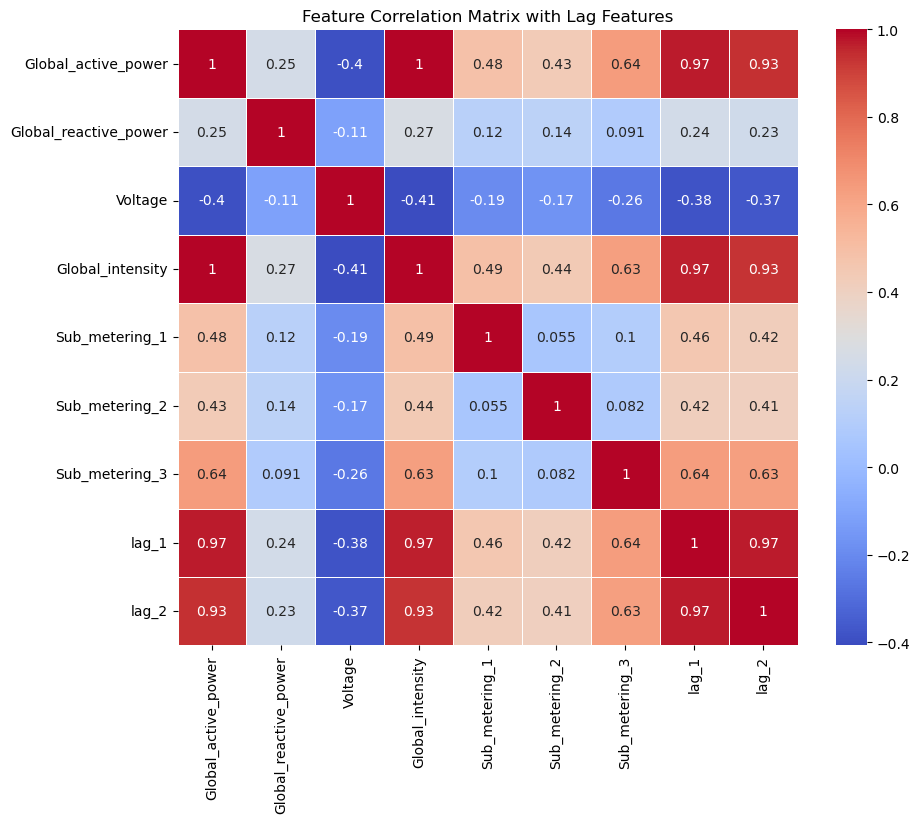

In [ ]:
# Feature engineering example: Creating lag features
data['lag_1'] = data['Global_active_power'].shift(1)
data['lag_2'] = data['Global_active_power'].shift(2)

# Drop NaN values created by lag features
data.dropna(inplace=True)

# Check the impact of new features on correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix with Lag Features')
plt.show()


## Model evaluation and tuning

In [ ]:
import itertools
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore warnings
warnings.filterwarnings("ignore")

# Generate all possible combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define a function for grid search
def grid_search_arima(train_data):
    best_aic = np.inf
    best_params = None

    for param in pdq:
        try:
            model = ARIMA(train_data, order=param)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = param
        except:
            continue

    return best_params, best_aic

# Example usage:
# Assuming 'train' is your training dataset
best_params, best_aic = grid_search_arima(train)

print(f'Best ARIMA parameters: {best_params} with AIC: {best_aic}')


Best ARIMA parameters: (2, 1, 2) with AIC: 2576.3259015377153


## Future Consumption Prediction

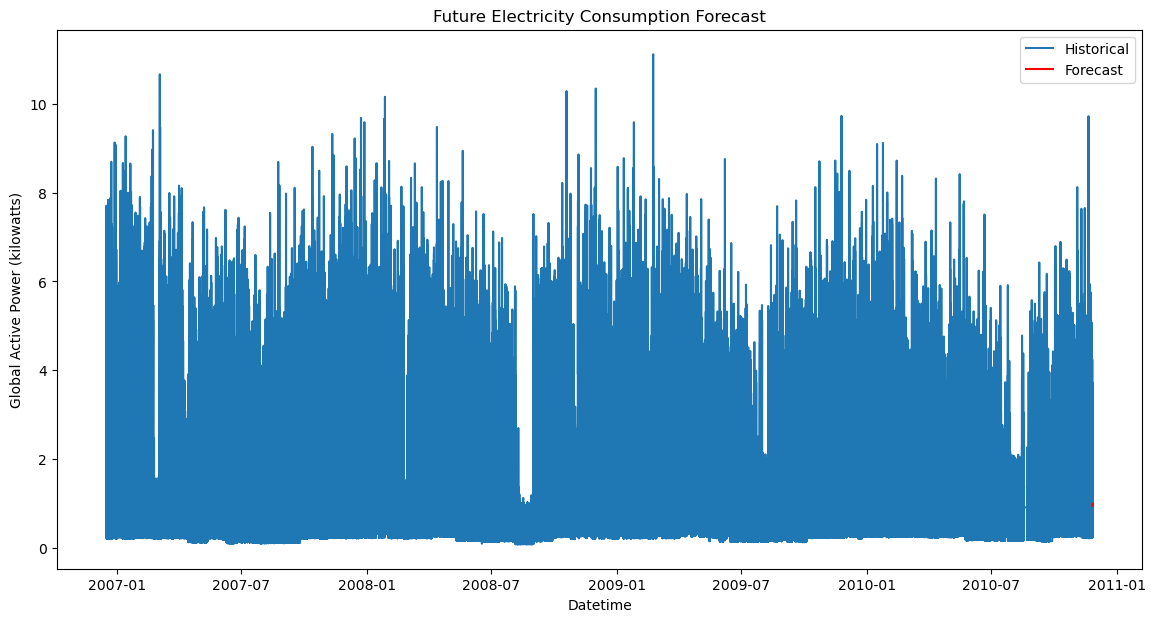

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'series' is your time series data for 'Global_active_power'
# and 'best_params' is the tuple of the best ARIMA parameters obtained from grid search

# Fit the best ARIMA model
best_model = ARIMA(series, order=best_params)
best_model_fit = best_model.fit()

# Forecast future values
forecast_steps = 100  # For example, forecast 100 steps ahead
forecast = best_model_fit.forecast(steps=forecast_steps)

# Create a datetime index for the forecast
forecast_index = pd.date_range(start=series.index[-1], periods=forecast_steps + 1, freq='T')[1:]

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(series.index, series, label='Historical')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Future Electricity Consumption Forecast')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()
